In [ ]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import pull_data, load_training_data, pull_prediction_data, pull_projections
from train_model import split_data, create_baseline, tune_model, create_model
from validate_and_combine import plot_predictions, compile_predictions, combine_projections
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import pandas as pd
from datetime import datetime

START_YEAR = 2017
END_YEAR = 2023
AGG_YEARS = 5
PRED_YEAR = 2024
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.2
PITCHER_SPLIT = 0.4
BATTER_SPLIT = 0.6

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

# Columns for modeling player performance
batting_stat_cols = ['IDfg', 'Season', 'Name', 'Age', 'G', 'AB', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'HBP', 'BB', 'IBB', 'SO', 'K%', 'SB', 'AVG', 'OBP', 'SLG', 'OPS', 'BABIP', 'RAR', 'WAR', 'wRC+', 'Spd', 'WPA', 'Contact%', 'Barrels', 'Barrel%', 'HardHit', 'wOBA', 'SwStr%', 'BsR', 'Soft%', 'Hard%', 'FB%', 'EV', 'HardHit%']
pitching_stat_cols = ['IDfg', 'Season', 'Name', 'Age', 'G', 'GS', 'Pitches', 'Strikes', 'W', 'WAR', 'xERA', 'ERA', 'IP', 'TBF', 'H', 'ER', 'HR', 'BB', 'SO', 'AVG', 'WHIP', 'BABIP', 'FIP', 'SwStr%', 'CSW%', 'HR/FB', 'FB', 'FBv', 'FB%', 'WPA', 'RAR', 'Swing%', 'K%', 'BB%', 'SIERA', 'Soft%', 'Barrel%', 'HardHit', 'Hard%', 'Pitching+', 'Location+', 'Stuff+']

In [2]:
batting_df, pitching_df = pull_data(start_year = START_YEAR,
                                    end_year = END_YEAR, 
                                    agg_years=AGG_YEARS, 
                                    save_results=True,
                                    batting_stat_cols=batting_stat_cols, 
                                    pitching_stat_cols=pitching_stat_cols)

Gathering player lookup table. This may take a moment.
Data saved successfully.


# Pulling FantasyPros Projection Data

In [ ]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [4]:
display(batting_projections.head())

,first_name,last_name,Team,Positions,projected_fantasy_points
0,shohei,ohtani,LAD,"SP,DH",1742
1,aaron,judge,NYY,"LF,CF,RF,DH",1709
2,bobby,witt,KC,SS,1615
3,jose,ramirez,CLE,"3B,DH",1516
4,fernando,tatis,SD,RF,1470


In [5]:
# Reading in training data
batting_df, pitching_df = load_training_data()

KeyboardInterrupt: 

In [6]:
display(batting_df)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,Hard%_prior,FB%_prior,EV_prior,HardHit%_prior,fantasy_points_prior,fantasy_points_future,covid_season,covid_impact,rookie_year,years_in_league
0,15640,2017,Aaron Judge,25,155,542,154,75,24,3,...,0.488,0.512,95.1,0.581,149.0,1152.0,False,False,2016.0,1.0
1,5417,2017,Jose Altuve,27,153,590,204,137,39,4,...,0.257,0.305,87.2,0.323,7314.0,1236.0,False,False,2011.0,6.0
2,13510,2017,Jose Ramirez,24,152,585,186,95,56,6,...,0.251,0.347,87.8,0.297,2352.0,1783.0,False,False,2013.0,4.0
3,15429,2017,Kris Bryant,25,151,549,162,91,38,4,...,0.390,0.455,89.5,0.415,3122.0,933.0,False,False,2015.0,2.0
4,10155,2017,Mike Trout,25,114,402,123,62,25,3,...,0.377,0.382,91.9,0.443,8978.0,1658.0,False,False,2011.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3717,5933,2023,Jean Segura,33,85,301,66,56,5,2,...,0.289,0.281,87.7,0.348,5635.0,0.0,False,True,2012.0,11.0
3718,20970,2023,Oscar Gonzalez,25,54,173,37,26,7,2,...,0.336,0.284,88.6,0.398,701.0,0.0,False,True,2022.0,1.0
3719,19901,2023,Gavin Sheets,27,118,311,63,43,10,0,...,0.320,0.428,89.2,0.386,1088.0,771.0,False,True,2021.0,2.0
3720,14691,2023,Harold Castro,29,99,258,65,51,13,0,...,0.299,0.262,87.6,0.334,1897.0,0.0,False,True,2018.0,5.0


In [7]:
display(pitching_df)

,IDfg,Season,Name,Age,G,W,WAR,xERA,ERA,GS,...,Hard%_prior,Pitching+_prior,Location+_prior,Stuff+_prior,fantasy_points_prior,fantasy_points_future,covid_season,covid_impact,rookie_year,years_in_league
0,10603,2017,Chris Sale,28,32,17,7.6,2.68,2.90,32,...,0.273,0.0,0.0,0.0,6159.6,1134.0,False,False,2010.0,7.0
1,2429,2017,Corey Kluber,31,29,18,7.2,2.59,2.25,29,...,0.271,0.0,0.0,0.0,4775.3,1204.0,False,False,2011.0,6.0
2,3137,2017,Max Scherzer,32,31,16,6.4,2.49,2.51,31,...,0.285,0.0,0.0,0.0,7315.3,1464.6,False,False,2008.0,9.0
3,10131,2017,Stephen Strasburg,28,28,15,5.9,2.92,2.52,28,...,0.282,0.0,0.0,0.0,4952.3,746.0,False,False,2010.0,7.0
4,15890,2017,Luis Severino,23,31,14,5.6,3.10,2.98,31,...,0.280,0.0,0.0,0.0,607.3,1112.3,False,False,2015.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3583,19316,2023,Eric Lauer,28,10,4,-0.8,7.54,6.56,9,...,0.380,97.0,98.0,99.0,2629.0,0.0,False,True,2018.0,5.0
3584,2429,2023,Corey Kluber,37,15,3,-0.8,6.28,7.04,9,...,0.313,96.0,102.0,98.0,3845.3,0.0,False,True,2011.0,12.0
3585,13763,2023,Dominic Leone,31,51,1,-0.8,5.30,4.67,0,...,0.361,96.0,95.0,101.0,1328.6,0.0,False,True,2014.0,9.0
3586,14527,2023,Jorge Lopez,30,61,6,-0.9,5.41,5.95,0,...,0.352,100.0,98.0,101.0,1638.0,268.0,False,True,2015.0,8.0


## Defining Baseline Model

In [9]:
# Splitting data
x_train, x_test, y_train, y_test = split_data(batting_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), y_train, y_test)

Root Mean Squared Error: 293.1418458482714
R^2 Score: 0.5846580204434177


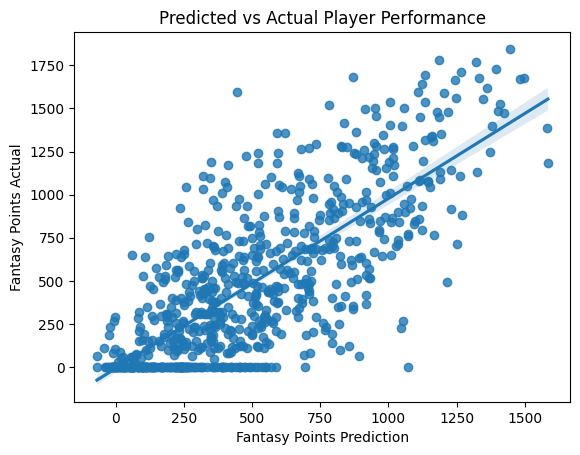

In [10]:
plot_predictions(x_test, y_test, y_pred)

In [11]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

,Name,fantasy_points_future,fantasy_points_pred,diff,Season,Age,fantasy_points,fantasy_points_prior
140,Jorge Soler,1593.0,443.489410,1149.510590,2018,26,512,1579.0
458,Fernando Tatis Jr.,0.0,1072.357544,1072.357544,2021,22,1476,1616.0
252,J.J. Bleday,1189.0,349.517700,839.482300,2023,25,529,363.0
417,Miguel Sano,64.0,893.203125,829.203125,2021,28,1074,4816.0
722,Odubel Herrera,226.0,1044.130859,818.130859,2018,26,1071,3328.0
...,...,...,...,...,...,...,...,...
670,Aaron Nola,61.0,59.024822,1.975178,2018,25,23,63.0
122,Jimmy Nelson,0.0,-1.263799,1.263799,2017,28,25,70.0
130,Andrew Velazquez,177.0,178.130142,1.130142,2022,27,528,287.0
426,Charlie Morton,0.0,-1.125970,1.125970,2021,37,36,16.0


# Creating baseline pitching predictions

In [12]:
# Splitting data
x_train, x_test, y_train, y_test = split_data(pitching_df)
# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), y_train, y_test)

Root Mean Squared Error: 213.22233440876587
R^2 Score: 0.4779120839488703


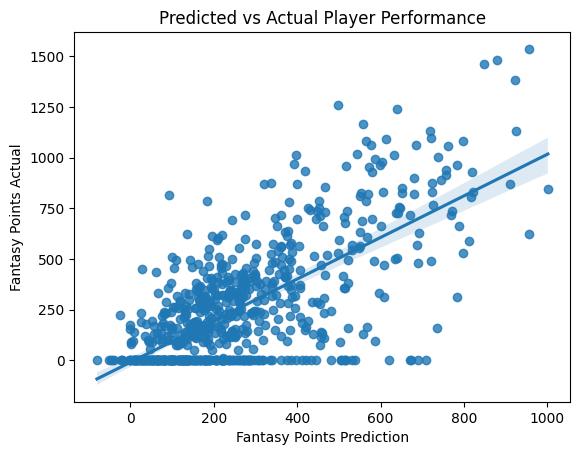

In [13]:
plot_predictions(x_test, y_test, y_pred)

In [14]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

,Name,fantasy_points_future,fantasy_points_pred,diff,Season,Age,fantasy_points,fantasy_points_prior
702,Shane Bieber,1260.3,496.825562,763.474438,2018,23,577.6,0.0
506,Dakota Hudson,815.6,92.342125,723.257875,2018,23,134.3,0.0
150,Lance McCullers Jr.,0.0,707.828186,707.828186,2018,24,695.3,1781.3
665,Stephen Strasburg,0.0,689.563904,689.563904,2019,30,1239.0,5651.3
190,Aaron Ashby,0.0,671.852844,671.852844,2022,24,550.3,177.6
...,...,...,...,...,...,...,...,...
545,Mike Fiers,228.0,229.922562,1.922562,2019,34,765.6,3549.3
415,Packy Naughton,138.0,137.031357,0.968643,2021,25,54.6,0.0
333,Neil Ramirez,102.0,101.717453,0.282547,2018,29,213.6,608.0
477,T.J. Zeuch,0.0,-0.193320,0.193320,2019,23,95.6,0.0


# Building Final Models

In [ ]:
# Define the hyperparameter search space
n_estimators_list = [50, 100, 200, 300]
max_depth_list = [4, 6, 8, 10]

space = {
    "n_estimators": hp.choice("n_estimators", n_estimators_list),
    "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
    "max_depth": hp.choice("max_depth", max_depth_list),
    "subsample": hp.uniform("subsample", 0.5, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

# Batting Predictions

In [ ]:
# Splitting data
x_train, x_test, y_train, y_test = split_data(batting_df)
# Tuning model
best_params = tune_model(x_train.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), y_train, y_test, n_estimators_list, max_depth_list, space)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:46<00:00,  2.32s/trial, best loss: 292.06652300978465]
Best Parameters: {'n_estimators': 50, 'learning_rate': np.float64(0.14952178504401506), 'max_depth': 4, 'subsample': np.float64(0.6634028430351142), 'colsample_bytree': np.float64(0.606966819839408)}


In [17]:
batting_model, y_pred = create_model(x_train.drop(columns=['IDfg']), x_test.drop(columns='IDfg'), y_train, y_test, best_params)

Root Mean Squared Error: 292.06652300978465
R^2 Score: 0.587699602868297


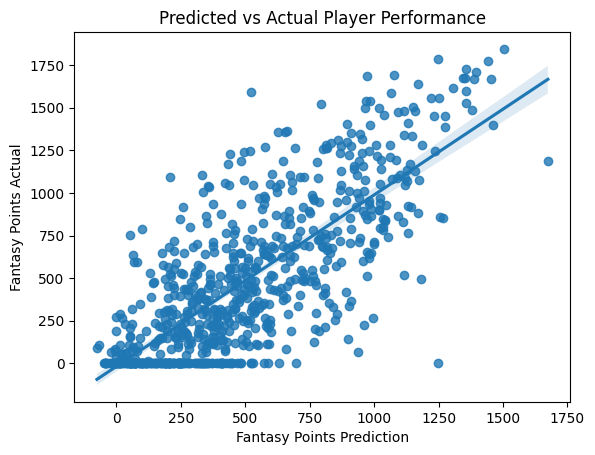

In [18]:
plot_predictions(x_test, y_test, y_pred)

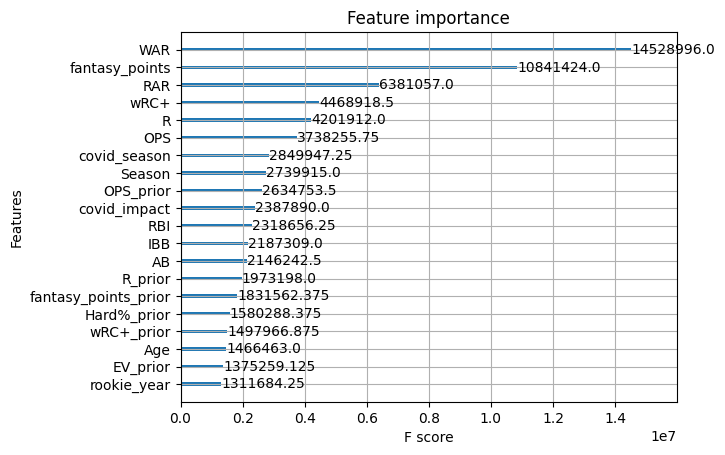

In [19]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=20)
plt.show()

In [20]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

,Name,fantasy_points_future,fantasy_points_pred,diff,Season,Age,fantasy_points,fantasy_points_prior
458,Fernando Tatis Jr.,0.0,1248.790771,1248.790771,2021,22,1476,1616.0
140,Jorge Soler,1593.0,521.855164,1071.144836,2018,26,512,1579.0
298,Michael Busch,1095.0,209.318115,885.681885,2023,25,119,0.0
417,Miguel Sano,64.0,935.700684,871.700684,2021,28,1074,4816.0
427,Jorge Soler,1226.0,441.242188,784.757812,2022,30,532,4204.0
...,...,...,...,...,...,...,...,...
478,Blake Swihart,0.0,-1.883667,1.883667,2019,27,149,1036.0
171,Steve Pearce,0.0,1.300214,1.300214,2019,36,127,3537.0
706,Ivan Nova,0.0,-0.882447,0.882447,2018,31,5,17.0
651,Jonathan Davis,0.0,-0.358167,0.358167,2019,27,132,0.0


# Pitching Predictions

In [21]:
# Splitting data
x_train, x_test, y_train, y_test = split_data(pitching_df)
# Tuning model
best_params = tune_model(x_train.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), y_train, y_test)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [00:44<00:00,  2.24s/trial, best loss: 206.91822750414772]
Best Parameters: {'n_estimators': 300, 'learning_rate': np.float64(0.08000184817702641), 'max_depth': 4, 'subsample': np.float64(0.8954292383358085), 'colsample_bytree': np.float64(0.6353009957201561)}


In [22]:
pitching_model, y_pred = create_model(x_train.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), y_train, y_test, best_params)

Root Mean Squared Error: 206.91822750414772
R^2 Score: 0.5083276872358712


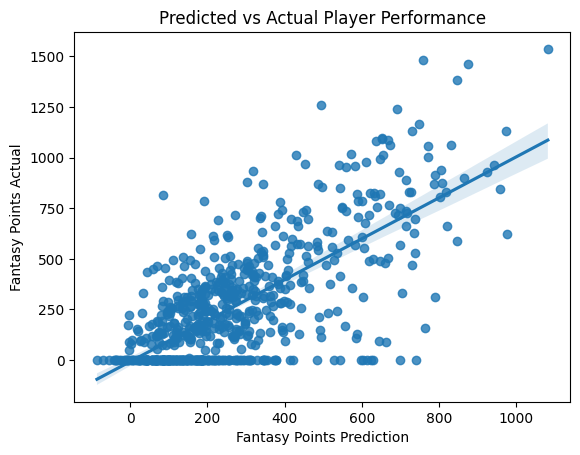

In [23]:
plot_predictions(x_test, y_test, y_pred)

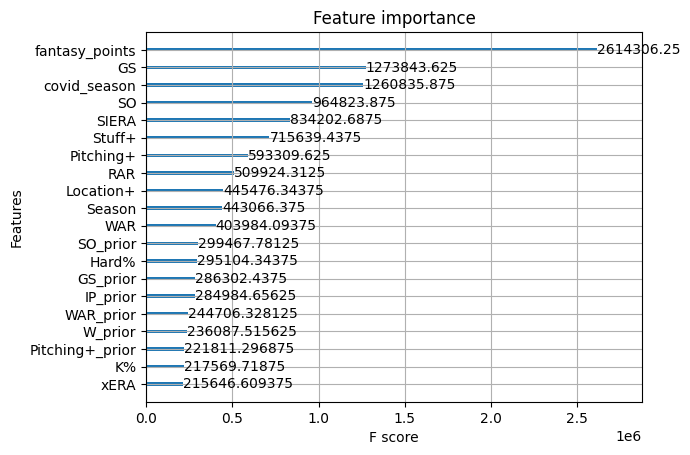

In [24]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=20)
plt.show()

In [25]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

,Name,fantasy_points_future,fantasy_points_pred,diff,Season,Age,fantasy_points,fantasy_points_prior
702,Shane Bieber,1260.3,494.093048,766.206952,2018,23,577.6,0.0
150,Lance McCullers Jr.,0.0,740.797729,740.797729,2018,24,695.3,1781.3
506,Dakota Hudson,815.6,84.114540,731.485460,2018,23,134.3,0.0
661,Justin Verlander,1482.0,759.872742,722.127258,2018,35,1412.0,6309.6
286,Noah Syndergaard,0.0,698.267578,698.267578,2019,26,965.6,2951.3
...,...,...,...,...,...,...,...,...
415,Packy Naughton,138.0,136.723892,1.276108,2021,25,54.6,0.0
74,Jeff Brigham,176.6,176.075623,0.524377,2022,30,129.0,240.6
390,Gregory Soto,123.0,122.544830,0.455170,2019,24,195.6,0.0
334,Dylan Floro,254.6,254.947983,0.347983,2021,30,348.0,787.6


# Predicting Upcoming Season Player Performance

In [27]:
# import pandas as pd
# from pybaseball import batting_stats, pitching_stats, playerid_reverse_lookup
# from helper import calc_fantasy_points_batting, calc_fantasy_points_pitching, add_suffix_to_columns, save_data, load_training_data
# def validate_covid_impact(season, years):
#     """
#     This function checks if the year 2020 occurred during the specified number of years leading up to the given season.
#     """
#     start_year = season - years
#     end_year = season
#     return 2020 in range(start_year, end_year + 1)

# def player_data(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Pulls player data from the pybaseball API and merges it with the provided DataFrame to obtain player rookie seasons.

#     Parameters:
#     df (pd.DataFrame): The DataFrame to which the player data will be added.

#     Returns:
#     pd.DataFrame: The DataFrame with the player data added.
#     """

#     player_ids = df['IDfg'].unique().tolist()
#     player_ids = playerid_reverse_lookup(player_ids, key_type='fangraphs').filter(items = ['key_fangraphs', 'mlb_played_first'])
#     player_ids = player_ids.rename(columns = {'key_fangraphs': 'IDfg', 'mlb_played_first': 'rookie_year'})
#     df = df.merge(player_ids, on = 'IDfg', how = 'left')
    
#     # Add total years in league to the data for each player for context on eligible playing years
#     df['years_in_league'] = df['Season'] - df['rookie_year']
#     return df

# def pull_prediction_data(prediction_year: int, agg_years: int, batting_stat_cols: list, pitching_stat_cols: list) -> tuple:
#     """
#     Pulls and processes batting and pitching data for the specified years.

#     Parameters:
#     end_year (int): The end year for the data pull.
#     agg_years (int): The number of years to aggregate for prior data.
#     batting_stat_cols (list): List of columns to include in the batting data.
#     pitching_stat_cols (list): List of columns to include in the pitching data.

#     Returns:
#     tuple: A tuple containing two DataFrames, one for batting data and one for pitching data.
#     """
#     # Initialize empty DataFrames
#     batting_df = pd.DataFrame()
#     pitching_df = pd.DataFrame()

#     # Creating start and end years for the aggregated data pull of prior player seasons
#     end_year_prior = prediction_year - 1
#     start_year_prior = end_year_prior - agg_years

#     # Pulling batting stats
#     batting_df_current = (
#         batting_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 50,
#                         split_seasons = True)
#                         .filter(items = batting_stat_cols)
#     )
#     calc_fantasy_points_batting(batting_df_current, 'fantasy_points')

#     batting_df_prior = (
#         batting_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 50,
#                         split_seasons = False)
#                         .filter(items = batting_stat_cols)
#     )
#     batting_df_prior = batting_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_batting(batting_df_prior, 'fantasy_points_prior')
#     batting_df_prior = add_suffix_to_columns(batting_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining batting features into single dataframe and replace NaN values with 0
#     batting_df_current = (batting_df_current.merge(batting_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Pulling pitching stats
#     pitching_df_current = (
#         pitching_stats(start_season = prediction_year, # Selecting a single season for most recent stats
#                         qual = 20,
#                         split_seasons = True)
#                         .filter(items = pitching_stat_cols)
#     )
#     calc_fantasy_points_pitching(pitching_df_current, 'fantasy_points')

#     pitching_df_prior = (
#         pitching_stats(start_season = start_year_prior, 
#                         end_season = end_year_prior,
#                         qual = 20,
#                         split_seasons = False)
#                         .filter(items = pitching_stat_cols)
#     )
#     pitching_df_prior = pitching_df_prior.drop(columns = ['Name', 'Age']) # Dropping redundant columns for joining
#     calc_fantasy_points_pitching(pitching_df_prior, 'fantasy_points_prior')
#     pitching_df_prior = add_suffix_to_columns(pitching_df_prior, '_prior', exclude_columns = ['IDfg', 'fantasy_points_prior'])

#     # Combining pitching features into single dataframe & replace NaN values with 0
#     pitching_df_current = (pitching_df_current.merge(pitching_df_prior, on = 'IDfg', how = 'left')
#     )

#     # Append the results to the main DataFrames
#     batting_df = pd.concat([batting_df, batting_df_current], ignore_index=True)
#     pitching_df = pd.concat([pitching_df, pitching_df_current], ignore_index=True)

#     # Add a column to indicate if the season is during the COVID-19 pandemic
#     batting_df['covid_season'] = batting_df['Season'] == 2020
#     pitching_df['covid_season'] = pitching_df['Season'] == 2020

#     # Add a column to indicate if the prior seasons were during the COVID-19 pandemic
#     batting_df['covid_impact'] = batting_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))
#     pitching_df['covid_impact'] = pitching_df['Season'].apply(lambda x: validate_covid_impact(x, agg_years))

#     # Add player rookie seasons onto the data, helps with modeling new players vs veterans
#     batting_df = player_data(batting_df)
#     pitching_df = player_data(pitching_df)

#     # Replacing NaN values with 0
#     batting_df.fillna(0, inplace=True)
#     pitching_df.fillna(0, inplace=True)

#     return batting_df, pitching_df

In [26]:
batting_new, pitching_new = pull_prediction_data(prediction_year=PRED_YEAR,
                                            agg_years=AGG_YEARS, 
                                            batting_stat_cols=batting_stat_cols, 
                                            pitching_stat_cols=pitching_stat_cols)

In [27]:
batting_predictions = batting_model.predict(batting_new.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_new.drop(columns=['IDfg', 'Name']))

In [28]:
batting_new['fantasy_points_pred'] = batting_predictions
pitching_new['fantasy_points_pred'] = pitching_predictions

batting_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_new.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [29]:
display(batting_new)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,Hard%_prior,FB%_prior,EV_prior,HardHit%_prior,fantasy_points_prior,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred
1,25764,2024,Bobby Witt Jr.,24,161,636,211,123,45,11,...,0.344,0.449,90.2,0.422,2859.0,False,True,2022.0,2.0,1567.222412
16,11579,2024,Bryce Harper,31,145,550,157,85,42,0,...,0.422,0.366,91.9,0.471,7633.0,False,True,2012.0,12.0,1531.516968
3,20123,2024,Juan Soto,25,157,576,166,90,31,4,...,0.376,0.328,92.0,0.495,8099.0,False,True,2018.0,6.0,1529.503174
10,19611,2024,Vladimir Guerrero Jr.,25,159,616,199,124,44,1,...,0.380,0.334,92.6,0.492,5992.0,False,True,2019.0,5.0,1475.618286
7,13510,2024,Jose Ramirez,31,158,620,173,93,39,2,...,0.350,0.465,89.1,0.377,8348.0,False,True,2013.0,11.0,1470.940430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,13355,2024,Luke Maile,33,55,135,24,18,4,0,...,0.305,0.366,86.4,0.328,1270.0,False,True,2015.0,9.0,21.807575
313,16953,2024,Chadwick Tromp,29,19,52,13,7,6,0,...,0.286,0.386,89.3,0.314,174.0,False,True,2020.0,4.0,21.562891
452,10200,2024,Tucker Barnhart,33,31,81,14,11,3,0,...,0.309,0.329,86.4,0.278,2839.0,False,True,2014.0,10.0,7.323224
467,5297,2024,Aaron Hicks,34,18,57,8,7,0,0,...,0.326,0.391,88.4,0.369,3805.0,False,True,2013.0,11.0,3.021378


In [30]:
display(pitching_new)

,IDfg,Season,Name,Age,G,W,WAR,xERA,ERA,GS,...,Hard%_prior,Pitching+_prior,Location+_prior,Stuff+_prior,fantasy_points_prior,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred
32,27782,2024,Brandon Pfaadt,25,32,11,3.1,3.78,4.71,32,...,0.386,105.0,104.0,102.0,402.0,False,True,2023.0,1.0,970.407715
10,25436,2024,George Kirby,26,33,14,4.2,3.44,3.53,33,...,0.322,108.0,111.0,100.0,1620.6,False,True,2022.0,2.0,947.202271
2,10310,2024,Zack Wheeler,34,32,16,5.4,2.80,2.57,32,...,0.272,118.0,105.0,113.0,5397.0,False,True,2013.0,11.0,943.661438
8,17995,2024,Logan Webb,27,33,13,4.4,4.31,3.47,33,...,0.298,106.0,102.0,105.0,3216.6,False,True,2019.0,5.0,906.599243
9,33677,2024,Paul Skenes,22,23,11,4.3,2.53,1.96,23,...,0.000,0.0,0.0,0.0,0.0,False,True,0.0,0.0,861.656860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,21045,2024,Seth Martinez,29,44,3,-0.2,4.08,3.59,0,...,0.312,98.0,96.0,104.0,408.6,False,True,2021.0,3.0,-26.345068
345,18769,2024,Cody Poteet,29,5,3,0.2,5.01,2.22,4,...,0.343,96.0,100.0,94.0,256.6,False,True,2021.0,3.0,-27.061567
516,6895,2024,Chase Anderson,36,29,0,-0.5,4.49,5.40,1,...,0.347,92.0,100.0,89.0,2020.0,False,True,2014.0,10.0,-33.493183
477,17149,2024,Domingo German,31,7,0,-0.2,5.56,7.84,2,...,0.361,95.0,100.0,94.0,2501.0,False,True,2017.0,7.0,-40.191101


In [31]:
batting_new = split_name(batting_new, 'Name')
pitching_new = split_name(pitching_new, 'Name')

In [33]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_new, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
479,13301.0,2024.0,Max Muncy,33.0,73.0,237.0,55.0,23.0,17.0,0.0,...,False,True,2015.0,9.0,691.386169,max,muncy,LAD,3B,1068.0
480,13301.0,2024.0,Max Muncy,33.0,73.0,237.0,55.0,23.0,17.0,0.0,...,False,True,2015.0,9.0,691.386169,max,muncy,ATH,"2B,SS",151.0


In [34]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 150
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 150))]

display(batting_final)

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,5297.0,2024.0,Aaron Hicks,34.0,18.0,57.0,8.0,7.0,0.0,0.0,...,False,True,2013.0,11.0,3.021378,aaron,hicks,NaN,DH,28.0
1,15640.0,2024.0,Aaron Judge,32.0,158.0,559.0,180.0,85.0,36.0,1.0,...,False,True,2016.0,8.0,1345.684326,aaron,judge,NYY,"LF,CF,RF,DH",1709.0
2,25524.0,2024.0,Aaron Schunk,26.0,39.0,94.0,22.0,17.0,3.0,0.0,...,False,True,0.0,0.0,64.997910,aaron,schunk,COL,"2B,3B",113.0
3,19844.0,2024.0,Abraham Toro,27.0,94.0,337.0,81.0,57.0,17.0,1.0,...,False,True,2019.0,5.0,477.741943,abraham,toro,BOS,"2B,3B",140.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,adael,amador,COL,2B,91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,31347.0,2024.0,Zach Neto,23.0,155.0,542.0,135.0,77.0,34.0,1.0,...,False,True,2023.0,1.0,1167.392822,zach,neto,LAA,SS,1087.0
710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zach,remillard,NaN,DH,64.0
711,31562.0,2024.0,Zachary Dezenzo,24.0,19.0,62.0,15.0,11.0,2.0,0.0,...,False,True,0.0,0.0,174.627716,zachary,dezenzo,NaN,NaN,NaN
712,29766.0,2024.0,Zack Gelof,24.0,138.0,497.0,105.0,66.0,20.0,2.0,...,False,True,2023.0,1.0,826.784729,zack,gelof,ATH,2B,1103.0


In [35]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_new, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,W,WAR,xERA,ERA,GS,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
600,6984.0,2024.0,Luis Garcia,37.0,60.0,5.0,0.3,3.56,4.88,0.0,...,False,True,2013.0,11.0,156.414749,luis,garcia,HOU,SP,544.4
601,6984.0,2024.0,Luis Garcia,37.0,60.0,5.0,0.3,3.56,4.88,0.0,...,False,True,2013.0,11.0,156.414749,luis,garcia,NaN,SP,275.1


In [36]:
# Filter the pitching_final DataFrame to drop rows where Name is Austin Adams or Luis Garcia and team is not NaN
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Austin Adams', 'Luis Garcia'])) & (pitching_final['Team'].notna()))]

display(pitching_final)

,IDfg,Season,Name,Age,G,W,WAR,xERA,ERA,GS,...,covid_season,covid_impact,rookie_year,years_in_league,fantasy_points_pred,first_name,last_name,Team,Positions,projected_fantasy_points
0,18655.0,2024.0,A.J. Minter,30.0,39.0,5.0,-0.1,3.31,2.62,0.0,...,False,True,2017.0,7.0,165.548660,a.j.,minter,NYM,RP,314.6
1,19343.0,2024.0,A.J. Puk,29.0,62.0,4.0,1.7,2.72,3.15,4.0,...,False,True,2019.0,5.0,356.794373,a.j.,puk,ARI,"SP,RP",381.5
2,23550.0,2024.0,Aaron Ashby,26.0,14.0,1.0,0.6,3.05,2.86,2.0,...,False,True,2021.0,3.0,252.072739,aaron,ashby,MIL,RP,455.2
3,12272.0,2024.0,Aaron Brooks,34.0,5.0,0.0,-0.1,6.70,5.06,4.0,...,False,True,2014.0,10.0,33.220093,aaron,brooks,NaN,NaN,NaN
4,16258.0,2024.0,Aaron Bummer,30.0,56.0,4.0,1.1,2.80,3.58,0.0,...,False,True,2017.0,7.0,260.448456,aaron,bummer,ATL,RP,358.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,20349.0,2024.0,Zack Kelly,29.0,49.0,6.0,-0.3,4.25,3.97,3.0,...,False,True,2022.0,2.0,207.723206,zack,kelly,BOS,"SP,RP",182.5
943,15823.0,2024.0,Zack Littell,28.0,29.0,8.0,2.3,4.34,3.63,29.0,...,False,True,2018.0,6.0,502.391937,zack,littell,TB,SP,606.2
944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zack,thompson,STL,"SP,RP",230.8
945,10310.0,2024.0,Zack Wheeler,34.0,32.0,16.0,5.4,2.80,2.57,32.0,...,False,True,2013.0,11.0,943.661438,zack,wheeler,PHI,SP,1071.7


In [37]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [38]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [39]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [61]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [40]:
# Reset the chained assignment option to its default value
pd.options.mode.chained_assignment = 'warn'

In [42]:
# Display the DataFrame to verify the changes
display(batting_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,5297.0,Aaron Hicks,34.0,NaN,DH,3.021378,28.0
1,15640.0,Aaron Judge,32.0,NYY,OF,1345.684326,1709.0
2,25524.0,Aaron Schunk,26.0,COL,2B,64.997910,113.0
3,19844.0,Abraham Toro,27.0,BOS,2B,477.741943,140.0
4,NaN,Adael Amador,NaN,COL,2B,NaN,91.0
...,...,...,...,...,...,...,...
709,31347.0,Zach Neto,23.0,LAA,SS,1167.392822,1087.0
710,NaN,Zach Remillard,NaN,NaN,DH,NaN,64.0
711,31562.0,Zachary Dezenzo,24.0,NaN,DH,174.627716,NaN
712,29766.0,Zack Gelof,24.0,ATH,2B,826.784729,1103.0


In [43]:
# Display the DataFrame to verify the changes
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points
0,18655.0,A.J. Minter,30.0,NYM,RP,165.548660,314.6
1,19343.0,A.J. Puk,29.0,ARI,SP,356.794373,381.5
2,23550.0,Aaron Ashby,26.0,MIL,RP,252.072739,455.2
3,12272.0,Aaron Brooks,34.0,NaN,SP,33.220093,NaN
4,16258.0,Aaron Bummer,30.0,ATL,RP,260.448456,358.1
...,...,...,...,...,...,...,...
942,20349.0,Zack Kelly,29.0,BOS,SP,207.723206,182.5
943,15823.0,Zack Littell,28.0,TB,SP,502.391937,606.2
944,NaN,Zack Thompson,NaN,STL,SP,NaN,230.8
945,10310.0,Zack Wheeler,34.0,PHI,SP,943.661438,1071.7


# Finalizing Predictions & Creating Relative Positional Value Scores

In [44]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])


pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [45]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final['final_projection'] = (batting_final['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final['initial_rank'] = batting_final['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [46]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool = round(player_pool * BATTER_SPLIT, 0)

In [47]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final = batting_final[batting_final['initial_rank'] <= batter_pool]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [48]:
display(pitching_final)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank
5,19479.0,Aaron Civale,29.0,MIL,SP,744.521423,673.9,723.334996,39.0
6,16149.0,Aaron Nola,31.0,PHI,SP,826.275635,941.4,860.812944,11.0
21,27451.0,Alec Marsh,26.0,KC,SP,496.504059,530.1,506.582841,113.0
24,NaN,Alex Cobb,NaN,DET,SP,539.300000,539.3,539.300000,100.0
37,26108.0,Andre Pallante,25.0,STL,SP,590.685303,603.7,594.589712,78.0
...,...,...,...,...,...,...,...,...,...
934,20633.0,Yusei Kikuchi,33.0,LAA,SP,703.415466,900.5,762.540826,28.0
935,19291.0,Zac Gallen,28.0,ARI,SP,516.092285,882.3,625.954600,68.0
938,13774.0,Zach Eflin,30.0,BAL,SP,692.871643,783.4,720.030150,41.0
943,15823.0,Zack Littell,28.0,TB,SP,502.391937,606.2,533.534356,102.0


In [56]:
# Adjusting positional group for Shoehei Ohtani to be DH within the batting_final dataframe
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'DH'
batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [57]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [59]:
# batting_final = calculate_relative_value(batting_final, position_col='position_group', projection_col='final_projection')
# pitching_final = calculate_relative_value(pitching_final, position_col='position_group', projection_col='final_projection')
# Calculating relative positional values
combined_df = calculate_relative_value(combined_df, position_col='position_group', projection_col='final_projection')
# Creating positional ranks based on player relative values
combined_df['position_rank'] = combined_df.groupby('Position')['relative_value'].rank(ascending=False, method='dense')

C:\Users\JB\AppData\Local\Temp\ipykernel_29228\1023020310.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['relative_value'].fillna(0, inplace=True)


In [60]:
display(combined_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank
0,15640.0,Aaron Judge,32.0,NYY,OF,1345.684326,1709.0,1454.679004,7.0,OF,3129.268340,7.0,2.0
1,26288.0,Adley Rutschman,26.0,BAL,C,1111.295532,1157.0,1125.006860,57.0,IF,506.906526,87.0,2.0
2,19287.0,Adolis Garcia,31.0,TEX,OF,634.036011,1171.0,795.125195,161.0,OF,-1050.912678,279.0,62.0
3,21618.0,Alec Bohm,27.0,PHI,1B,1176.339844,1142.0,1166.037866,39.0,IF,772.479550,59.0,6.0
4,27615.0,Alec Burleson,25.0,STL,1B,983.140259,922.0,964.798181,105.0,IF,-363.540676,180.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,20633.0,Yusei Kikuchi,33.0,LAA,SP,703.415466,900.5,762.540826,28.0,P,551.957452,82.0,28.0
284,19291.0,Zac Gallen,28.0,ARI,SP,516.092285,882.3,625.954600,68.0,P,-271.752578,163.0,68.0
285,13774.0,Zach Eflin,30.0,BAL,SP,692.871643,783.4,720.030150,41.0,P,261.683049,107.0,41.0
286,15823.0,Zack Littell,28.0,TB,SP,502.391937,606.2,533.534356,102.0,P,-649.675078,226.0,102.0


# Create Player Value Segments

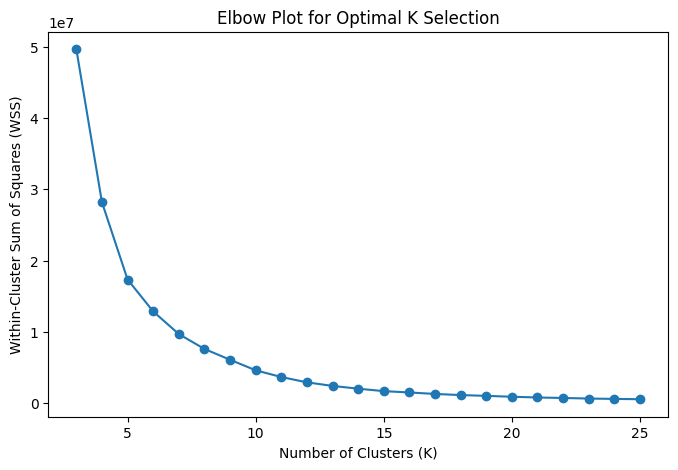

In [80]:
# Evaluating clustering performance on varying K values

determine_optimal_k(combined_df, max_k = 25)

In [82]:
# Setting a K of 15 and placing players into relative value tiers
final_df = segment_players(combined_df, k = 15)

In [83]:
display(final_df)

,IDfg,Name,Age,Team,Position,fantasy_points_pred,projected_fantasy_points,final_projection,initial_rank,position_group,relative_value,final_ranking,position_rank,player_value_tier
0,15640.0,Aaron Judge,32.0,NYY,OF,1345.684326,1709.0,1454.679004,7.0,OF,3129.268340,7.0,2.0,3
1,26288.0,Adley Rutschman,26.0,BAL,C,1111.295532,1157.0,1125.006860,57.0,IF,506.906526,87.0,2.0,9
2,19287.0,Adolis Garcia,31.0,TEX,OF,634.036011,1171.0,795.125195,161.0,OF,-1050.912678,279.0,62.0,15
3,21618.0,Alec Bohm,27.0,PHI,1B,1176.339844,1142.0,1166.037866,39.0,IF,772.479550,59.0,6.0,8
4,27615.0,Alec Burleson,25.0,STL,1B,983.140259,922.0,964.798181,105.0,IF,-363.540676,180.0,20.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,20633.0,Yusei Kikuchi,33.0,LAA,SP,703.415466,900.5,762.540826,28.0,P,551.957452,82.0,28.0,9
284,19291.0,Zac Gallen,28.0,ARI,SP,516.092285,882.3,625.954600,68.0,P,-271.752578,163.0,68.0,12
285,13774.0,Zach Eflin,30.0,BAL,SP,692.871643,783.4,720.030150,41.0,P,261.683049,107.0,41.0,10
286,15823.0,Zack Littell,28.0,TB,SP,502.391937,606.2,533.534356,102.0,P,-649.675078,226.0,102.0,14


In [ ]:
final_df.to_csv(f'data/final_df_{datetime.now().strftime('%Y')}.csv', index=False)